In [1]:
%matplotlib inline

source for dataset: https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/input?select=energy_dataset.csv

In [2]:
from io import open
import glob
import os
import unicodedata
import string

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import scipy as sc

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklego.preprocessing import RepeatingBasisFunction
from sklearn.preprocessing import FunctionTransformer


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction


# Cuda

In [3]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the name of the GPU device
    device = torch.device("cuda")
    print("GPU is available")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is not available, using CPU


/home/marcel/Documents/PyTorch/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Prepare data

In [4]:
energy_dataset = pd.read_csv("./energy_dataset.csv").sort_values(by='time', ascending=True)
weather_features = pd.read_csv("./weather_features.csv").sort_values(by='dt_iso', ascending=True)

In [5]:
weather_features["city_name"].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [6]:
energy_dataset.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

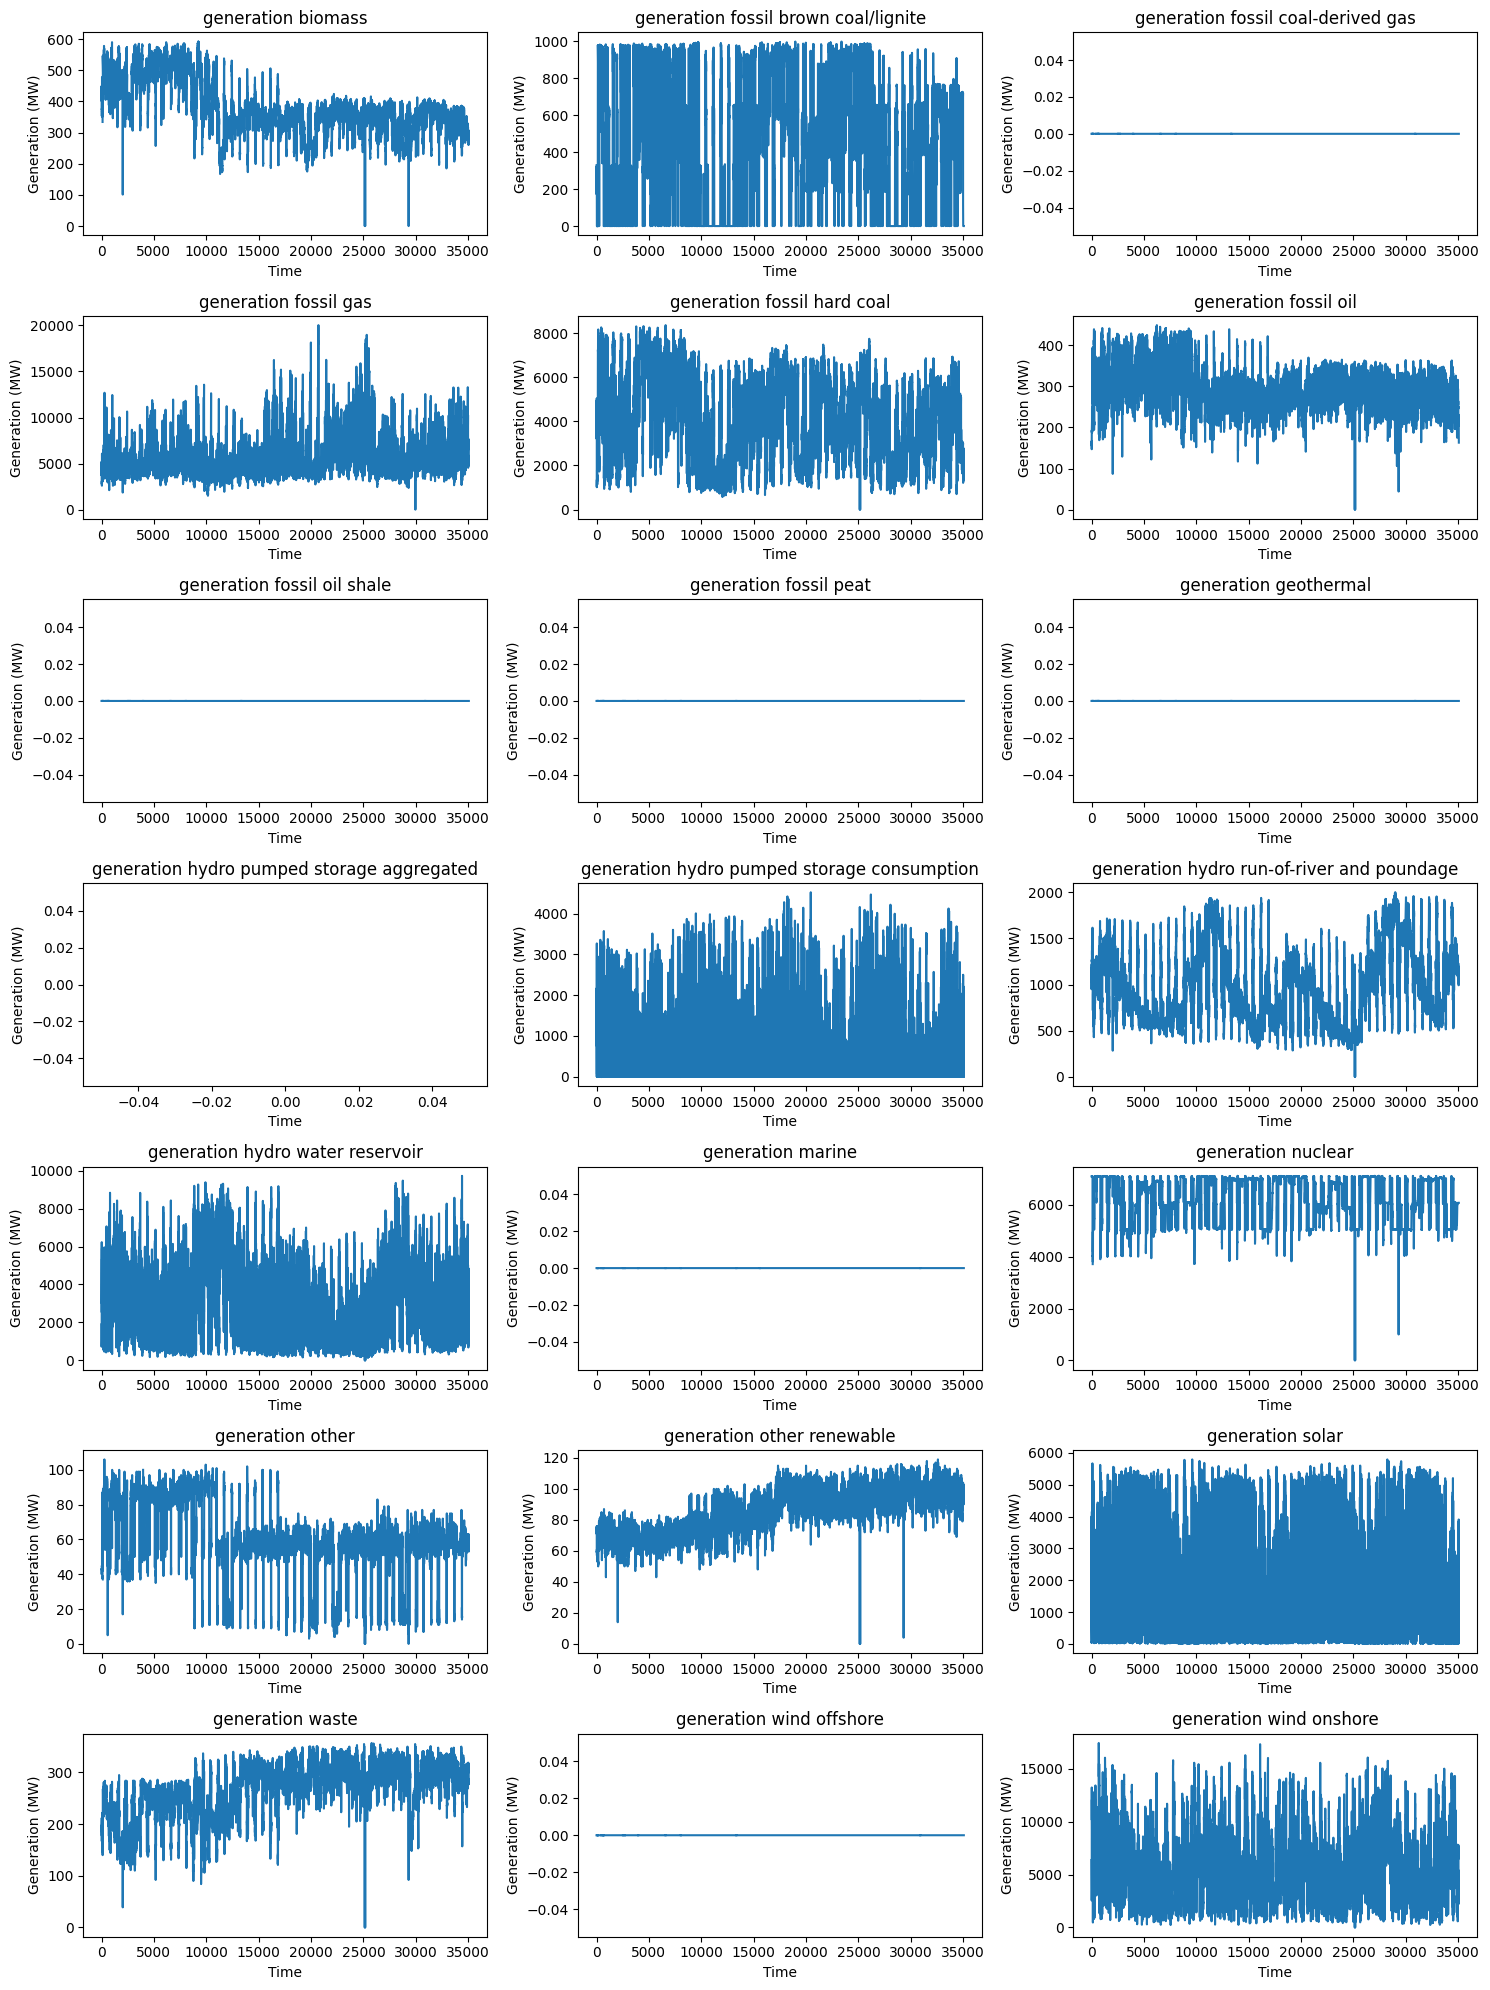

In [7]:
columns_to_plot = ['generation biomass', 'generation fossil brown coal/lignite',
                   'generation fossil coal-derived gas', 'generation fossil gas',
                   'generation fossil hard coal', 'generation fossil oil',
                   'generation fossil oil shale', 'generation fossil peat',
                   'generation geothermal', 'generation hydro pumped storage aggregated',
                   'generation hydro pumped storage consumption',
                   'generation hydro run-of-river and poundage',
                   'generation hydro water reservoir', 'generation marine',
                   'generation nuclear', 'generation other', 'generation other renewable',
                   'generation solar', 'generation waste', 'generation wind offshore',
                   'generation wind onshore']

# Plotting each selected column
plt.figure(figsize=(15, 20))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(7, 3, i)
    plt.plot(energy_dataset[column])
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Generation (MW)')
    plt.tight_layout()

plt.show()

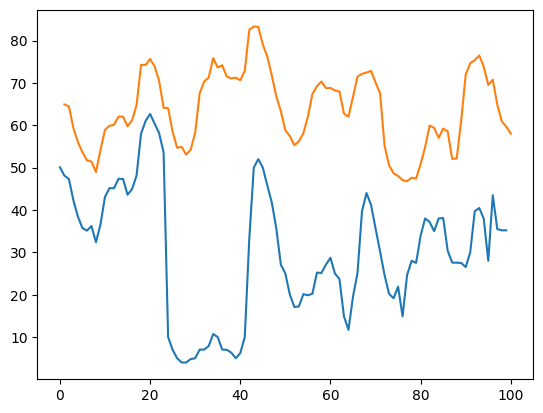

In [8]:
length = 0
plt.plot(energy_dataset['price day ahead'][length : length + 100])
plt.plot(energy_dataset['price actual'][length + 1 : length + 101])

plt.show()

In [9]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))



def prepareData(inputData):

    inputData['time'] = pd.to_datetime(inputData['time'], utc=True)

    X_2 = inputData.copy()

    X_2["month"] = X_2.time.dt.month
    X_2["day_of_year"] = X_2.time.dt.day_of_year
    X_2["hour"] = X_2.time.dt.hour

    X_2["month_sin"] = np.sin(2 * np.pi * X_2["month"]/12.0)
    X_2["month_cos"] = np.cos(2 * np.pi * X_2["month"]/12.0)

    X_2["day_sin"] = np.sin(2 * np.pi * X_2["day_of_year"]/365.0)
    X_2["day_cos"] = np.cos(2 * np.pi * X_2["day_of_year"]/365.0)

    X_2["hour_sin"] = np.sin(2 * np.pi * X_2["hour"]/24.0)
    X_2["hour_cos"] = np.cos(2 * np.pi * X_2["hour"]/24.0)

    return X_2[ ["month_sin", "month_cos", "day_sin", "day_cos", "hour_sin", "hour_cos", ] ]

In [10]:
length = int( 0.8 * len(energy_dataset) )

df_train = energy_dataset.iloc[0 : length].copy()
df_test = energy_dataset.iloc[length : -1].copy()

df_test.index = df_test.index.factorize()[0]

In [11]:
columns_to_scale = ['generation biomass', 'generation fossil brown coal/lignite',
                    'generation fossil gas',
                   'generation fossil hard coal', 'generation fossil oil',
                   'generation hydro pumped storage consumption',
                   'generation hydro run-of-river and poundage',
                   'generation hydro water reservoir', 
                   'generation nuclear', 'generation other', 'generation other renewable',
                   'generation solar', 'generation waste', 
                   'generation wind onshore',
                   'price actual']

time_column = prepareData(df_train).copy()
df = df_train[columns_to_scale].copy()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=columns_to_scale)

df_scaled[time_column.columns] = time_column
df_scaled = df_scaled[list( time_column.columns ) + columns_to_scale] 


df_train = df_scaled.dropna().copy()

In [12]:
price_pred = df_test.copy()
price_pred['price actual'] = price_pred["price day ahead"] 
price_pred = price_pred[columns_to_scale].dropna()

In [13]:
time_column = prepareData(df_test).copy()
df = df_test[columns_to_scale].copy()


df_scaled = pd.DataFrame(scaler.transform(df), columns=columns_to_scale)


df_scaled[time_column.columns] = time_column
df_scaled = df_scaled[list( time_column.columns ) + columns_to_scale] 


df_test = df_scaled.dropna().copy()

In [14]:

price_pred = pd.DataFrame(scaler.transform(price_pred[columns_to_scale]), columns=columns_to_scale)[:-1]


In [15]:
price_pred = price_pred['price actual']

In [16]:
df_test

,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,...,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,price actual
0,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-1.000000,-1.836970e-16,0.423986,0.0,0.205282,0.127766,...,0.168251,0.953584,0.680690,0.852606,0.566038,0.886957,0.005352,0.775910,0.818135,0.387271
1,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.965926,2.588190e-01,0.425676,0.0,0.203824,0.134705,...,0.032943,0.939144,0.719565,0.852606,0.518868,0.878261,0.004662,0.812325,0.763134,0.468968
2,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.866025,5.000000e-01,0.432432,0.0,0.151221,0.126092,...,0.037143,0.955647,0.650122,0.852606,0.500000,0.895652,0.002935,0.823529,0.743863,0.386713
3,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.707107,7.071068e-01,0.429054,0.0,0.136585,0.115205,...,0.179306,0.955647,0.569496,0.853309,0.509434,0.904348,0.002935,0.806723,0.750746,0.340653
4,1.000000e+00,6.123234e-17,9.510565e-01,0.309017,-0.500000,8.660254e-01,0.418919,0.0,0.119248,0.102046,...,0.443732,0.941723,0.557780,0.853449,0.500000,0.826087,0.002935,0.806723,0.768984,0.197823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-0.965926,-2.588190e-01,0.494932,0.0,0.328095,0.311521,...,0.000221,0.583290,0.426563,0.853168,0.575472,0.800000,0.045925,0.809524,0.169305,0.635340
7008,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-1.000000,-1.836970e-16,0.501689,0.0,0.330309,0.314392,...,0.000221,0.585353,0.515071,0.853309,0.594340,0.826087,0.014675,0.775910,0.178539,0.629850
7009,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-0.965926,2.588190e-01,0.500000,0.0,0.309084,0.306975,...,0.000221,0.604435,0.418681,0.853449,0.584906,0.826087,0.005698,0.784314,0.188575,0.621848
7010,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,-0.866025,5.000000e-01,0.493243,0.0,0.297418,0.289748,...,0.011055,0.592058,0.301523,0.853731,0.575472,0.817391,0.005352,0.801120,0.200906,0.604541


In [17]:
#train_data = prepareData(df_train)
train_dataset = {"x": df_train.iloc[:-1].values, "y": df_train[1:][ ["price actual"] ].values.reshape((-1, 1))}

#test_data = prepareData(df_test)
test_dataset = {"x": df_test.iloc[:-1].values, "y": df_test[1:][ ["price actual"] ].values.reshape((-1, 1))}

In [18]:
import random

def randomPair(len, maxSequence):
    a = random.randint(0, len - 1 - maxSequence)
    #return (a, random.randint(a + 1, a + maxSequence))
    return (a, a + maxSequence)

In [19]:
# generating pairs so I can run same test for all NN
pairs = np.empty((0, 2), dtype=np.int64)
for i in range(0, 100000):

    pairs = np.vstack((pairs, randomPair(len(df_train), 24)))

## Creating Networks

In [20]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # h_n = tanh( W*h_n-1 + U*x_n + b )
        # y_hat = softmax( V*h_n + c )
        
        inp = self.W(hidden)
        hid = self.U(input)

        hidden = inp + hid
        hidden = self.dropout(hidden)
        hidden = self.tanh(hidden)

        output = self.V(hidden)
        #print(output)
        #output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [34]:
class LTC_RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, steps, tau):
        super(LTC_RNN2, self).__init__()
        self.hidden_size = hidden_size
        self.steps = steps
        self.delta = 1/steps
        self.tau = tau

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size , hidden_size)
        self.V = nn.Linear(hidden_size, output_size)
        self.K = nn.Linear(hidden_size, input_size)

        self.A = nn.Linear(hidden_size, 1)


        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # f_n = tanh( W*h_n-1 + U*x_n + b )
        # h_n = ( h_n-1 + delta*f_n*A ) / ( 1 + delta*(1/tau + f_n) )
        # y_hat = softmax( V*h_n + c )

        h_n = hidden
        x_n = input
        for i in range(self.steps):
            f_n = self.f_n(h_n, x_n)
            h_n = self.h_n(h_n, f_n)
            x_n = self.K(h_n)
        output = self.V(h_n)
        #print(output)
        #output = self.softmax(output)

        return output, h_n
    
    def f_n(self, h_n, x_n):

        inp = self.W(h_n)
        hid = self.U(x_n)

        f_n = inp + hid
        f_n = self.dropout(f_n)
        f_n = self.tanh(f_n)

        return f_n

    def h_n(self, h_n, f_n):
        return (h_n + self.delta * self.A(f_n)) / (1 + self.delta * (1/self.tau + f_n))

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [36]:
class LTC_RNN4(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, steps, tau):
        super(LTC_RNN4, self).__init__()
        self.hidden_size = hidden_size
        self.steps = steps
        self.delta = 1/steps
        self.tau = tau

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size , hidden_size)
        self.V = nn.Linear(hidden_size, output_size)

        self.A = nn.Linear(hidden_size, 1)


        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # f_n = tanh( W*h_n-1 + U*x_n + b )
        # h_n = ( h_n-1 + delta*f_n*A ) / ( 1 + delta*(1/tau + f_n) )
        # y_hat = softmax( V*h_n + c )

        h_n = hidden
        x_n = input
        for i in range(self.steps):
            f_n = self.f_n(h_n, x_n)
            h_n = self.h_n(h_n, f_n)
        output = self.V(h_n)
        #print(output)
        #output = self.softmax(output)

        return output, h_n
    
    def f_n(self, h_n, x_n):

        inp = self.W(h_n)
        hid = self.U(x_n)

        f_n = inp + hid
        f_n = self.dropout(f_n)
        f_n = self.tanh(f_n)

        return f_n

    def h_n(self, h_n, f_n):
        return (h_n + self.delta * self.A(f_n)) / (1 + self.delta * (1/self.tau + f_n))

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [22]:
class LTC_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, delta, tau):
        super(LTC_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.delta = delta
        self.tau = tau

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, output_size)

        self.A = nn.Linear(hidden_size, 1)


        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # f_n = tanh( W*h_n-1 + U*x_n + b )
        # h_n = ( h_n-1 + delta*f_n*A ) / ( 1 + delta*(1/tau + f_n) )
        # y_hat = softmax( V*h_n + c )
        
        inp = self.W(hidden)
        hid = self.U(input)

        f_n = inp + hid
        f_n = self.dropout(f_n)
        f_n = self.tanh(f_n)

        h_n = (hidden + self.delta * self.A(f_n)) / (1 + self.delta * (1/self.tau + f_n))

        output = self.V(h_n)
        #print(output)
        #output = self.softmax(output)

        return output, h_n

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [23]:
class LTC_RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, delta, tau):
        super(LTC_RNN3, self).__init__()
        self.hidden_size = hidden_size
        self.delta = delta
        self.tau = tau

        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(input_size, hidden_size)

        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.U1 = nn.Linear(input_size, hidden_size)

        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.U2 = nn.Linear(input_size, hidden_size)

        self.V = nn.Linear(hidden_size, output_size)

        self.A = nn.Linear(hidden_size, 1)
        self.A1 = nn.Linear(hidden_size, 1)
        self.A2 = nn.Linear(hidden_size, 1)


        self.dropout = nn.Dropout(0.1)
        #self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):

        # f_n = tanh( W*h_n-1 + U*x_n + b )
        # h_n = ( h_n-1 + delta*f_n*A ) / ( 1 + delta*(1/tau + f_n) )
        # y_hat = softmax( V*h_n + c )


        hid = self.W(hidden)
        i_0 = self.U(input)

        f_1 = self.f(hid, i_0)
        h_1 = self.h(hidden, f_1, self.A)


        hid = self.W1(h_1)
        i_1 = self.U1(input)

        f_2 = self.f(hid, i_1)
        h_2 = self.h(h_1, f_2, self.A1)


        hid = self.W2(h_2)
        i_2 = self.U2(input)

        f_3 = self.f(hid, i_2)
        h_3 = self.h(h_2, f_3, self.A2)

        output = self.V(h_3)
        hidden = h_3

        #print(output)
        #output = self.softmax(output)

        return output, hidden
    
    def f(self, hidden, input):

        f_n = hidden + input
        f_n = self.dropout(f_n)
        f_n = self.tanh(f_n)

        return f_n
    
    def h(self, hidden, f_n, A):
        return (hidden + self.delta * A(f_n)) / (1 + self.delta * (1/self.tau + f_n))

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [24]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Training

In [25]:
import torch.optim as optim

criterion = nn.MSELoss()
learning_rate = 0.0005

def train(input_tensor_batch, target_tensor_batch, rnn, optimizer):
    rnn.zero_grad()
    loss = torch.Tensor([0.]).to(device)


    for i in range(len(input_tensor_batch)):
        input_line_tensor = input_tensor_batch[i]
        target_line_tensor = target_tensor_batch[i]

        hidden = rnn.initHidden().to(device)
        batch_loss = torch.Tensor([0.]).to(device)

        for j in range(len(input_line_tensor)):
            output, hidden = rnn(input_line_tensor[j], hidden)
            l = criterion(output, target_line_tensor[j])
            batch_loss += l

        loss += batch_loss / len(input_line_tensor)

    loss.backward()

    optimizer.step()

    return output, loss.item() / len(input_tensor_batch)


In [26]:
train_dataset["x"] = torch.from_numpy( train_dataset["x"] ).to(torch.float32).to(device)
train_dataset["y"] = torch.from_numpy( train_dataset["y"] ).to(torch.float32).to(device)
pairs = torch.from_numpy( pairs ).to(torch.int).to(device)

In [27]:
input_size  = len( train_dataset["x"][0] )
output_size = 1 #len( train_dataset["y"][0] )
hidden_size = 30

In [28]:
def training_model(rnn):
    optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)


    n_iters = 5000
    print_every = 100
    plot_every = 500
    all_losses = []
    total_loss = 0.0  
    batch_size = 10 


    start = time.time()

    for iter in range(1, n_iters + 1):
        batch_indices = torch.randint(0, len(train_dataset["x"]), size=(batch_size,))
        
        input_batch = [train_dataset["x"][pairs[i][0]:pairs[i][1]] for i in batch_indices]
        target_batch = [train_dataset["y"][pairs[i][0]:pairs[i][1]] for i in batch_indices]

        output, loss = train(input_batch, target_batch, rnn, optimizer)
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0.0

In [53]:
rnn = [ RNN(input_size, hidden_size, output_size).to(device) for i in range(1) ]
for r in rnn:
    training_model(r)


0m 5s (100 2%) 0.0262
0m 10s (200 4%) 0.0165
0m 16s (300 6%) 0.0189
0m 22s (400 8%) 0.0129
0m 27s (500 10%) 0.0097
0m 33s (600 12%) 0.0159
0m 38s (700 14%) 0.0105
0m 44s (800 16%) 0.0114
0m 49s (900 18%) 0.0072
0m 54s (1000 20%) 0.0078
1m 0s (1100 22%) 0.0073
1m 5s (1200 24%) 0.0054
1m 10s (1300 26%) 0.0045
1m 15s (1400 28%) 0.0056
1m 21s (1500 30%) 0.0043
1m 26s (1600 32%) 0.0044
1m 31s (1700 34%) 0.0048
1m 36s (1800 36%) 0.0051
1m 41s (1900 38%) 0.0039
1m 47s (2000 40%) 0.0032
1m 52s (2100 42%) 0.0031
1m 57s (2200 44%) 0.0030
2m 2s (2300 46%) 0.0033
2m 7s (2400 48%) 0.0029
2m 12s (2500 50%) 0.0040
2m 18s (2600 52%) 0.0023
2m 25s (2700 54%) 0.0026
2m 31s (2800 56%) 0.0027
2m 37s (2900 57%) 0.0025
2m 43s (3000 60%) 0.0030
2m 48s (3100 62%) 0.0027
2m 54s (3200 64%) 0.0029
2m 59s (3300 66%) 0.0027
3m 5s (3400 68%) 0.0021
3m 11s (3500 70%) 0.0037
3m 16s (3600 72%) 0.0031
3m 22s (3700 74%) 0.0025
3m 28s (3800 76%) 0.0021
3m 33s (3900 78%) 0.0020
3m 39s (4000 80%) 0.0016
3m 46s (4100 82%) 0

In [35]:
ltc_rnn2 = [ LTC_RNN2(input_size, hidden_size, output_size, 5, 0.4*torch.ones(1, 1).to(device)).to(device) for i in range(1) ]
for r in ltc_rnn2:
    training_model(r)

/home/marcel/Documents/PyTorch/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0m 31s (100 2%) 0.0105
1m 2s (200 4%) 0.0183
1m 33s (300 6%) 0.0171
2m 4s (400 8%) 0.0216
2m 35s (500 10%) 0.0124
3m 6s (600 12%) 0.0078
3m 37s (700 14%) 0.0146
4m 8s (800 16%) 0.0152
4m 39s (900 18%) 0.0073
5m 10s (1000 20%) 0.0130
5m 40s (1100 22%) 0.0126
6m 11s (1200 24%) 0.0163
6m 41s (1300 26%) 0.0262
7m 11s (1400 28%) 0.0062
7m 41s (1500 30%) 0.0110
8m 11s (1600 32%) 0.0135
8m 41s (1700 34%) 0.0167
9m 12s (1800 36%) 0.0111
9m 43s (1900 38%) 0.0132
10m 13s (2000 40%) 0.0098
10m 44s (2100 42%) 0.0211
11m 14s (2200 44%) 0.0132
11m 45s (2300 46%) 0.0079
12m 16s (2400 48%) 0.0130
12m 46s (2500 50%) 0.0207
13m 17s (2600 52%) 0.0096
13m 47s (2700 54%) 0.0146
14m 17s (2800 56%) 0.0144
14m 48s (2900 57%) 0.0130
15m 19s (3000 60%) 0.0152
15m 49s (3100 62%) 0.0087
16m 20s (3200 64%) 0.0190
16m 51s (3300 66%) 0.0085
17m 21s (3400 68%) 0.0073
17m 52s (3500 70%) 0.0111
18m 22s (3600 72%) 0.0078
18m 53s (3700 74%) 0.0155
19m 23s (3800 76%) 0.0057
19m 54s (3900 78%) 0.0026
20m 25s (4000 80%) 0.0

In [37]:
ltc_rnn4 = [ LTC_RNN4(input_size, hidden_size, output_size, 5, 0.4*torch.ones(1, 1).to(device)).to(device) for i in range(1) ]
for r in ltc_rnn4:
    training_model(r)

0m 30s (100 2%) 0.0079
1m 0s (200 4%) 0.0126
1m 30s (300 6%) 0.0134
1m 59s (400 8%) 0.0082
2m 29s (500 10%) 0.0043
3m 0s (600 12%) 0.0058
3m 31s (700 14%) 0.0045
4m 2s (800 16%) 0.0036
4m 33s (900 18%) 0.0021
5m 3s (1000 20%) 0.0026
5m 33s (1100 22%) 0.0024
6m 5s (1200 24%) 0.0016
6m 37s (1300 26%) 0.0022
7m 8s (1400 28%) 0.0015
7m 40s (1500 30%) 0.0023
8m 12s (1600 32%) 0.0013
8m 42s (1700 34%) 0.0014
9m 13s (1800 36%) 0.0019
9m 44s (1900 38%) 0.0026
10m 15s (2000 40%) 0.0011
10m 46s (2100 42%) 0.0013
11m 17s (2200 44%) 0.0014
11m 48s (2300 46%) 0.0014
12m 19s (2400 48%) 0.0012
12m 50s (2500 50%) 0.0015
13m 21s (2600 52%) 0.0013
13m 53s (2700 54%) 0.0014
14m 25s (2800 56%) 0.0011
14m 56s (2900 57%) 0.0008
15m 27s (3000 60%) 0.0013
16m 0s (3100 62%) 0.0013
16m 32s (3200 64%) 0.0012
17m 3s (3300 66%) 0.0013
17m 35s (3400 68%) 0.0010
18m 7s (3500 70%) 0.0009
18m 38s (3600 72%) 0.0010
19m 8s (3700 74%) 0.0009
19m 39s (3800 76%) 0.0010
20m 10s (3900 78%) 0.0008
20m 41s (4000 80%) 0.0012
21

In [46]:
ltc_rnn6 = [ LTC_RNN4(input_size, hidden_size, output_size, 20, 0.4*torch.ones(1, 1).to(device)).to(device) for i in range(1) ]
for r in ltc_rnn6:
    training_model(r)

/home/marcel/Documents/PyTorch/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1m 57s (100 2%) 0.0114
3m 58s (200 4%) 0.0096
5m 59s (300 6%) 0.0062
7m 58s (400 8%) 0.0109
10m 1s (500 10%) 0.0125
12m 1s (600 12%) 0.0073
13m 57s (700 14%) 0.0039
15m 55s (800 16%) 0.0064
17m 53s (900 18%) 0.0033
19m 48s (1000 20%) 0.0024
21m 43s (1100 22%) 0.0026
23m 38s (1200 24%) 0.0015
25m 33s (1300 26%) 0.0014
27m 36s (1400 28%) 0.0010
29m 41s (1500 30%) 0.0013
31m 46s (1600 32%) 0.0018
33m 48s (1700 34%) 0.0008
35m 46s (1800 36%) 0.0011
37m 48s (1900 38%) 0.0013
39m 51s (2000 40%) 0.0011
41m 54s (2100 42%) 0.0009
43m 54s (2200 44%) 0.0017
45m 55s (2300 46%) 0.0013
47m 57s (2400 48%) 0.0014
50m 0s (2500 50%) 0.0010
51m 58s (2600 52%) 0.0009
53m 58s (2700 54%) 0.0012
55m 57s (2800 56%) 0.0012
57m 55s (2900 57%) 0.0010
59m 53s (3000 60%) 0.0009
61m 45s (3100 62%) 0.0013
63m 43s (3200 64%) 0.0008
65m 45s (3300 66%) 0.0008
67m 46s (3400 68%) 0.0009
69m 44s (3500 70%) 0.0011
71m 46s (3600 72%) 0.0007
73m 49s (3700 74%) 0.0010
75m 50s (3800 76%) 0.0010
77m 50s (3900 78%) 0.0013
79m 50

In [ ]:
ltc_rnn = [LTC_RNN(input_size, hidden_size, output_size, 1, 0.4*torch.ones(1, 1).to(device)).to(device) for i in range(5) ]
for r in ltc_rnn:
    training_model(r)

In [50]:
ltc_rnn3 = LTC_RNN3(input_size, hidden_size, output_size, 1, torch.ones(1, 1).to(device)).to(device)

optimizer = optim.Adam(ltc_rnn3.parameters(), lr=learning_rate)

n_iters = 5000
print_every = 10
plot_every = 500
all_losses = []
total_loss = 0.0 
batch_size = 10  

start = time.time()

for iter in range(1, n_iters + 1):

    batch_indices = torch.randint(0, len(train_dataset["x"]), size=(batch_size,))
    
    input_batch = [train_dataset["x"][pairs[i][0]:pairs[i][1]] for i in batch_indices]
    target_batch = [train_dataset["y"][pairs[i][0]:pairs[i][1]] for i in batch_indices]

    output, loss = train(input_batch, target_batch, ltc_rnn3, optimizer)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 5s (10 0%) 0.1332
0m 10s (20 0%) 0.0363
0m 16s (30 0%) 0.0252
0m 21s (40 0%) 0.0106
0m 27s (50 1%) 0.0145
0m 32s (60 1%) 0.0138
0m 37s (70 1%) 0.0089
0m 43s (80 1%) 0.0108
0m 48s (90 1%) 0.0074
0m 53s (100 2%) 0.0139
0m 59s (110 2%) 0.0119
1m 5s (120 2%) 0.0210
1m 10s (130 2%) 0.0151
1m 15s (140 2%) 0.0147
1m 21s (150 3%) 0.0098
1m 26s (160 3%) 0.0119
1m 31s (170 3%) 0.0108
1m 36s (180 3%) 0.0198
1m 41s (190 3%) 0.0095
1m 47s (200 4%) 0.0168
1m 52s (210 4%) 0.0124
1m 58s (220 4%) 0.0097
2m 3s (230 4%) 0.0116
2m 8s (240 4%) 0.0081
2m 14s (250 5%) 0.0087
2m 19s (260 5%) 0.0117
2m 24s (270 5%) 0.0137
2m 30s (280 5%) 0.0112
2m 35s (290 5%) 0.0066
2m 40s (300 6%) 0.0080
2m 46s (310 6%) 0.0084
2m 51s (320 6%) 0.0093
2m 56s (330 6%) 0.0089
3m 2s (340 6%) 0.0094
3m 7s (350 7%) 0.0105
3m 12s (360 7%) 0.0075
3m 17s (370 7%) 0.0120
3m 23s (380 7%) 0.0095
3m 28s (390 7%) 0.0103
3m 34s (400 8%) 0.0119
3m 39s (410 8%) 0.0123
3m 45s (420 8%) 0.0082
3m 50s (430 8%) 0.0062
3m 55s (440 8%) 0.0080
4m 

In [39]:
test_dataset["x"] = torch.from_numpy( test_dataset["x"] ).to(torch.float32).to(device)
test_dataset["y"] = torch.from_numpy( test_dataset["y"] ).to(torch.float32).to(device)

In [40]:
def getSamples(input_line_tensor, rnn):
    
    with torch.no_grad():

        output_list = []#torch.from_numpy(np.array([])).to(device)
        
        hidden = rnn.initHidden().to(device)
        for i in range(len( input_line_tensor)):
            #print(input_line_tensor[i])
            output, hidden = rnn(input_line_tensor[i], hidden)
            #print(output)
            output_list.append(output[0][0].item())
        return torch.tensor( output_list )

In [54]:
ltc2  = getSamples(test_dataset["x"], ltc_rnn2[0])
ltc4  = getSamples(test_dataset["x"], ltc_rnn4[0])
ltc5  = getSamples(test_dataset["x"], ltc_rnn5[0])
ltc6  = getSamples(test_dataset["x"], ltc_rnn6[0])
r  = getSamples(test_dataset["x"], rnn[0])


In [43]:
first_rows = torch.tensor( [row[0].item() for row in test_dataset["y"]] )

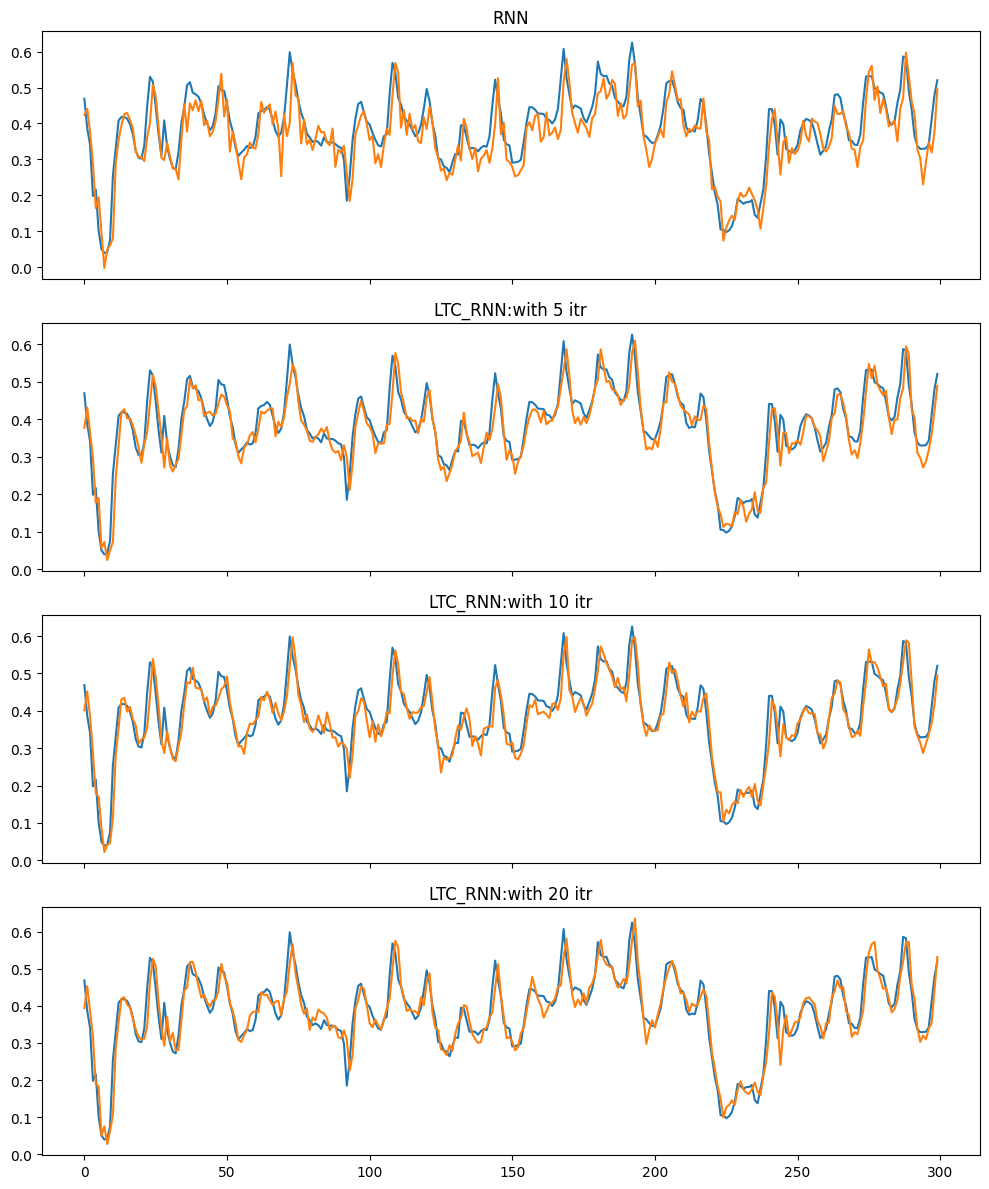

In [57]:

fr = 0
to = 300

fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

axs[0].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[0].plot(r[fr:to], label="RNN")
axs[0].set_title("RNN")

axs[1].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[1].plot(ltc4[fr:to], label="LTC_RNN:with 5 itr")
axs[1].set_title("LTC_RNN:with 5 itr")

axs[2].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[2].plot(ltc5[fr:to], label="LTC_RNN:with 10 itr")
axs[2].set_title("LTC_RNN:with 10 itr")

axs[3].plot(test_dataset["y"][fr:to].cpu(), label="Original")
axs[3].plot(ltc6[fr:to], label="LTC_RNN:with 20 itr")
axs[3].set_title("LTC_RNN:with 20 itr")



plt.tight_layout()
plt.show()

In [57]:
#old tests
print( f"RNN: {torch.var_mean( first_rows - r)}" )
print( f"LTC_RNN: {torch.var_mean( first_rows - l)}" )
print( f"LTC_RNN2: {torch.var_mean( first_rows - l2)}" )
print( f"LTC_RNN3: {torch.var_mean( first_rows - l3)}" )
print( f"LTC_RNN4: {torch.var_mean( first_rows - l4)}" )

RNN: (tensor(0.0009), tensor(0.0063))
LTC_RNN: (tensor(0.0011), tensor(0.0078))
LTC_RNN2: (tensor(0.0010), tensor(0.0055))
LTC_RNN3: (tensor(0.0007), tensor(0.0119))
LTC_RNN4: (tensor(0.0010), tensor(0.0184))


In [56]:
print( f"RNN: {torch.var_mean( first_rows - r)}" )
print( f"LTC_RNN with 5  itr: {torch.var_mean( first_rows - ltc4)}" )
print( f"LTC_RNN:with 10 itr: {torch.var_mean( first_rows - ltc5)}" )
print( f"LTC_RNN:with 20 itr: {torch.var_mean( first_rows - ltc6)}" )

RNN: (tensor(0.0016), tensor(0.0150))
LTC_RNN with 5  itr: (tensor(0.0007), tensor(0.0101))
LTC_RNN:with 10 itr: (tensor(0.0007), tensor(0.0045))
LTC_RNN:with 20 itr: (tensor(0.0007), tensor(0.0034))
